In [1]:
import keras
import glob 
import os
import tensorflow as tf
import random
from utils import imgs_input_fn, imgs_input_fn_val, rmse, build_model, _parse_function_train, _parse_function_val
import mdn
import pandas as pd
from tqdm import tqdm
import imageio
import numpy as np
from mdn import sample_from_output
import matplotlib.pyplot as plt
from utils import build_model, find_closest_element, Fy
from scipy.stats import norm

#define paths
# directory where checkpoints should be saved
model_dir = '../../../../data/models/mdn_cpl/export/'
checkpoint_path = '../../../../data/models/mdn_cpl/export/'

In [2]:
# define model and load weights from training
keras_model = build_model()

# load weights
keras_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) 

In [3]:
path_all_imgs = '../../../../data/commaai/training_files_filtered/indices/val_indices.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../../data/commaai/train_bags_2/'
density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

no_samp = 1000

# preds Bzetas by reading in images and predicting
preds = []
samples = []
labels  = []
for i in tqdm(range(0,all_img_df.shape[0])): 
    img = imageio.imread(str(img_path_base + all_img_df.loc[i,'path']))[:,:,0:3]/255
    pred = keras_model.predict(img.reshape(1,66,200,3))   
    y_samples = np.array([np.apply_along_axis(sample_from_output, 1, pred, 1, 50, temp=1.0) for i in range(0,no_samp)])
    samples.append(y_samples)
    label = all_img_df.loc[i,'angle']
    labels.append(label) 
    preds.append(pred)

100%|██████████| 10472/10472 [2:04:26<00:00,  1.40it/s] 


In [10]:
np.save('../../../../data/commaai/predictions/mdn/cpl/labels.npy', np.array(labels))
np.save('../../../../data/commaai/predictions/mdn/cpl/preds.npy', np.array(preds))
np.save('../../../../data/commaai/predictions/mdn/cpl/samples.npy', np.array(samples))

In [5]:
samples = np.array(samples)

In [6]:
pred_mdn = np.mean(samples.reshape(-1, 1000), axis = 1)

In [11]:
np.save('../../../../data/commaai/predictions/mdn/cpl/mdn_preds.npy', np.array(pred_mdn))

In [9]:
print("Performance of models without and with uncertainty" +
     "\nMSE:" +
      "\nwith uncertainty: " + str(np.mean((labels - pred_mdn.reshape(10472,))**2)) +
      "\nMAE:" +
      "\nwith uncertainty: " + str(np.mean(np.abs(labels - pred_mdn.reshape(10472,)))) +
      "\nAccuracy :" +
      "\nwith uncertainty: " + str(np.mean([np.abs((labels - pred_mdn.reshape(10472,))) <= 6])) +
      "\nAccuracy II:" +
      "\nwith uncertainty: " + str(np.mean([np.abs(labels - pred_mdn.reshape(10472,)) <= 2])) 
     )

Performance of models without and with uncertainty
MSE:
with uncertainty: 6.6299157147124514
MAE:
with uncertainty: 1.361488987986964
Accuracy :
with uncertainty: 0.9815699006875478
Accuracy II:
with uncertainty: 0.8191367456073338


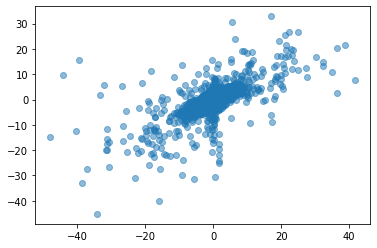

In [8]:
plt.scatter(labels, pred_mdn, alpha = 0.5)